In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import joblib
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.optim as optim

from tqdm import tqdm
import numpy as np
df = pd.read_csv('/kaggle/input/yahoofi/stock_details_5_years.csv')
# Show the first 5 unique company names
unique_companies = df['Company'].unique()[:6]
print(unique_companies)
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

aal_df = df[df['Company'] == 'AAPL'].copy()
aal_df.set_index('Date', inplace=True)  # Set date as index for time-based operations
print(f"AAPL Stock Data Shape: {aal_df.shape}")


# Select features and target
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'

features = aal_df[feature_cols].values.astype(np.float32)
target = aal_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()


scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))
# Save the scaler for inference
joblib.dump(target_scaler, 'target_scaler.pkl')

# Print scaler stats (verify)
print(f"Original mean: ${target_scaler.mean_[0]:.2f}")
print(f"Original std: ${target_scaler.scale_[0]:.2f}")
# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

['AAPL' 'MSFT' 'GOOGL' 'AMZN' 'NVDA' 'META']
✅ Original Data:
📐 Shape: (602962, 9)
🧾 Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Company']

🔍 Sample Data:
                        Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00           0.0    AAPL  
1   28123200       0.00           0.0    MSFT  
2   31004000       0.00           0.0   GOOGL  
3  132264000       0.00           0.0    AMZN  
4   54917200       0.04           0.0    NVDA  


/tmp/ipykernel_35/3610795770.py:31: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


AAPL Stock Data Shape: (1258, 8)
Original mean: $118.99
Original std: $46.98
Dataset sizes:
Training: 877 sequences
Validation: 187 sequences
Testing: 189 sequences
torch.Size([16, 5, 5])
torch.Size([16, 5, 5])


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import DataLoader, TensorDataset

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class StockTransformer(nn.Module):
    def __init__(self, input_features=5, d_model=256, nhead=8, num_layers=6, dropout=0.2):
        super(StockTransformer, self).__init__()
        
        # Input embedding layer (projects features to d_model dimension)
        self.embedding = nn.Linear(input_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Decoder (outputs single value for next day's close)
        self.decoder = nn.Linear(d_model, 1)
        
        # Initialize weights
        self.init_weights()
        self.d_model = d_model

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src shape: (batch_size, seq_len, input_features)
        src = src.transpose(0, 1)  # Transformer expects (seq_len, batch_size, features)
        
        # Embed the input
        src = self.embedding(src) * math.sqrt(self.d_model)
        
        # Add positional encoding
        src = self.pos_encoder(src)
        
        # Transformer encoder
        output = self.transformer_encoder(src)
        
        # We only care about the last time step's output for prediction
        last_output = output[-1]
        
        # Decode to single value
        output = self.decoder(last_output)
        
        return output.squeeze(-1)  # Remove last dimension for (batch_size,) shape

# Hyperparameters
input_features = 5  # open, high, low, close, volume
d_model = 256        # Dimension of the model
nhead = 8           # Number of attention heads
num_layers = 6     # Number of transformer layers
dropout = 0.2       # Dropout rate
learning_rate = 0.001
num_epochs = 50

# Initialize model, loss, and optimizer
model = StockTransformer(input_features, d_model, nhead, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch   | Train Loss   | Val Loss   | Time   | Status
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


1       | 0.158916 | 0.032919 | 3.02s | ✅ Improved


2       | 0.084734 | 0.043926 | 3.38s | ⏳ No improvement


3       | 0.073873 | 0.014849 | 2.93s | ✅ Improved


4       | 0.071366 | 0.011226 | 3.05s | ✅ Improved


5       | 0.062954 | 0.044835 | 2.90s | ⏳ No improvement


6       | 0.055962 | 0.029991 | 2.88s | ⏳ No improvement


7       | 0.054257 | 0.007575 | 3.06s | ✅ Improved


8       | 0.052592 | 0.008409 | 2.90s | ⏳ No improvement


9       | 0.048983 | 0.007474 | 2.91s | ✅ Improved


10      | 0.046658 | 0.024367 | 2.94s | ⏳ No improvement


11      | 0.048087 | 0.010170 | 2.96s | ⏳ No improvement


12      | 0.040128 | 0.010104 | 2.91s | ⏳ No improvement


13      | 0.036987 | 0.012367 | 3.24s | ⏳ No improvement


14      | 0.037205 | 0.008418 | 2.96s | 🛑 Early Stop
Early stopping at epoch 14

Training Complete!
Best Validation Loss: 0.007474


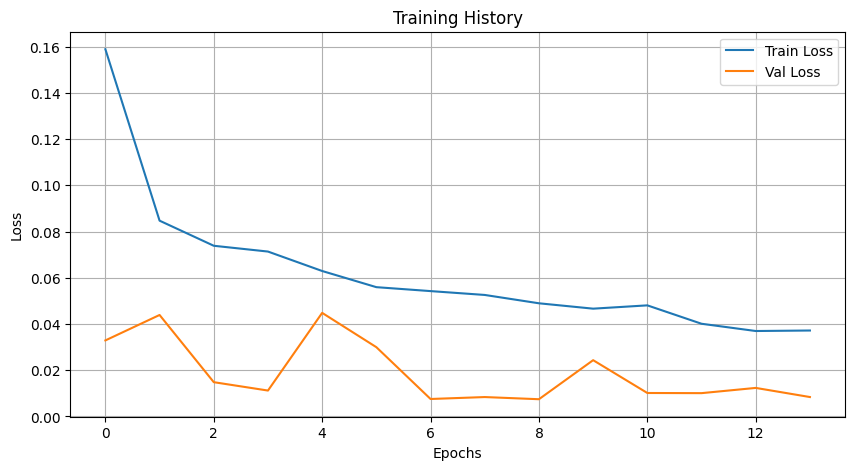

In [41]:
from tqdm import tqdm
import time
# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_transformer(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, patience=5):
    """Train the Transformer model with enhanced progress tracking"""
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Better regularization
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3)
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    # Training header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Val Loss':<10} | {'Time':<6} | Status")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss = 0
        
        # Create progress bar for batches
        with tqdm(train_loader, unit="batch", leave=False) as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for X_batch, y_batch in tepoch:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.squeeze())
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                # Update progress bar
                tepoch.set_postfix(loss=loss.item())
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val.squeeze()).item()
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_transformer.pth')
            status = "✅ Improved"
        else:
            patience_counter += 1
            status = "⏳ No improvement"
            if patience_counter >= patience:
                status = "🛑 Early Stop"
        
        # Print epoch summary
        epoch_time = time.time() - epoch_start
        print(f"{epoch+1:<7} | {train_loss:.6f} | {val_loss:.6f} | {epoch_time:.2f}s | {status}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Final training report
    print("\nTraining Complete!")
    print(f"Best Validation Loss: {best_loss:.6f}")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
    return model


trained_model = train_transformer(
        model, 
        train_loader, 
        val_loader,
        num_epochs=50,
        learning_rate=0.001,
        patience=5
    )


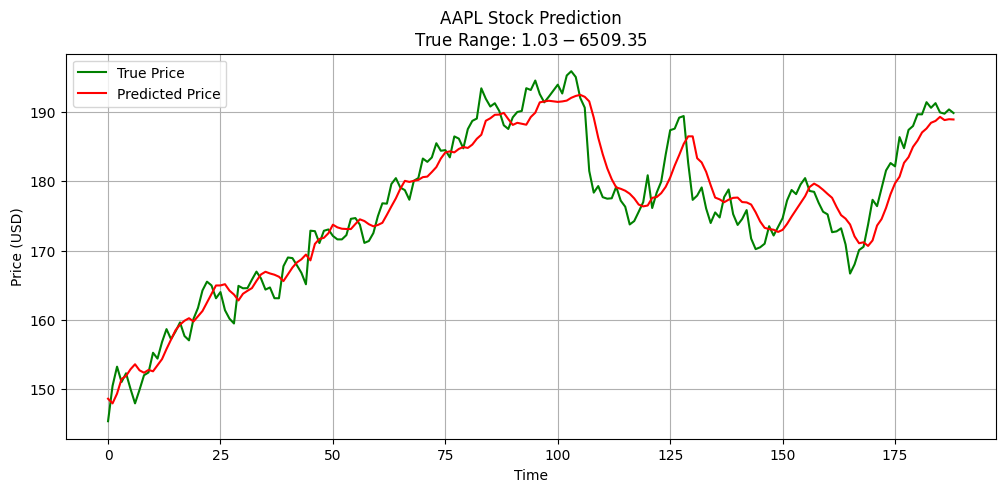


Normalized Metrics:
RMSE: 0.0676
MAE: 0.0546
R²: 0.9236

Denormalized Metrics (USD):
RMSE: $3.18 (2.3% of mean price)
MAE: $2.57
MAPE (>$5 prices): 1.46%


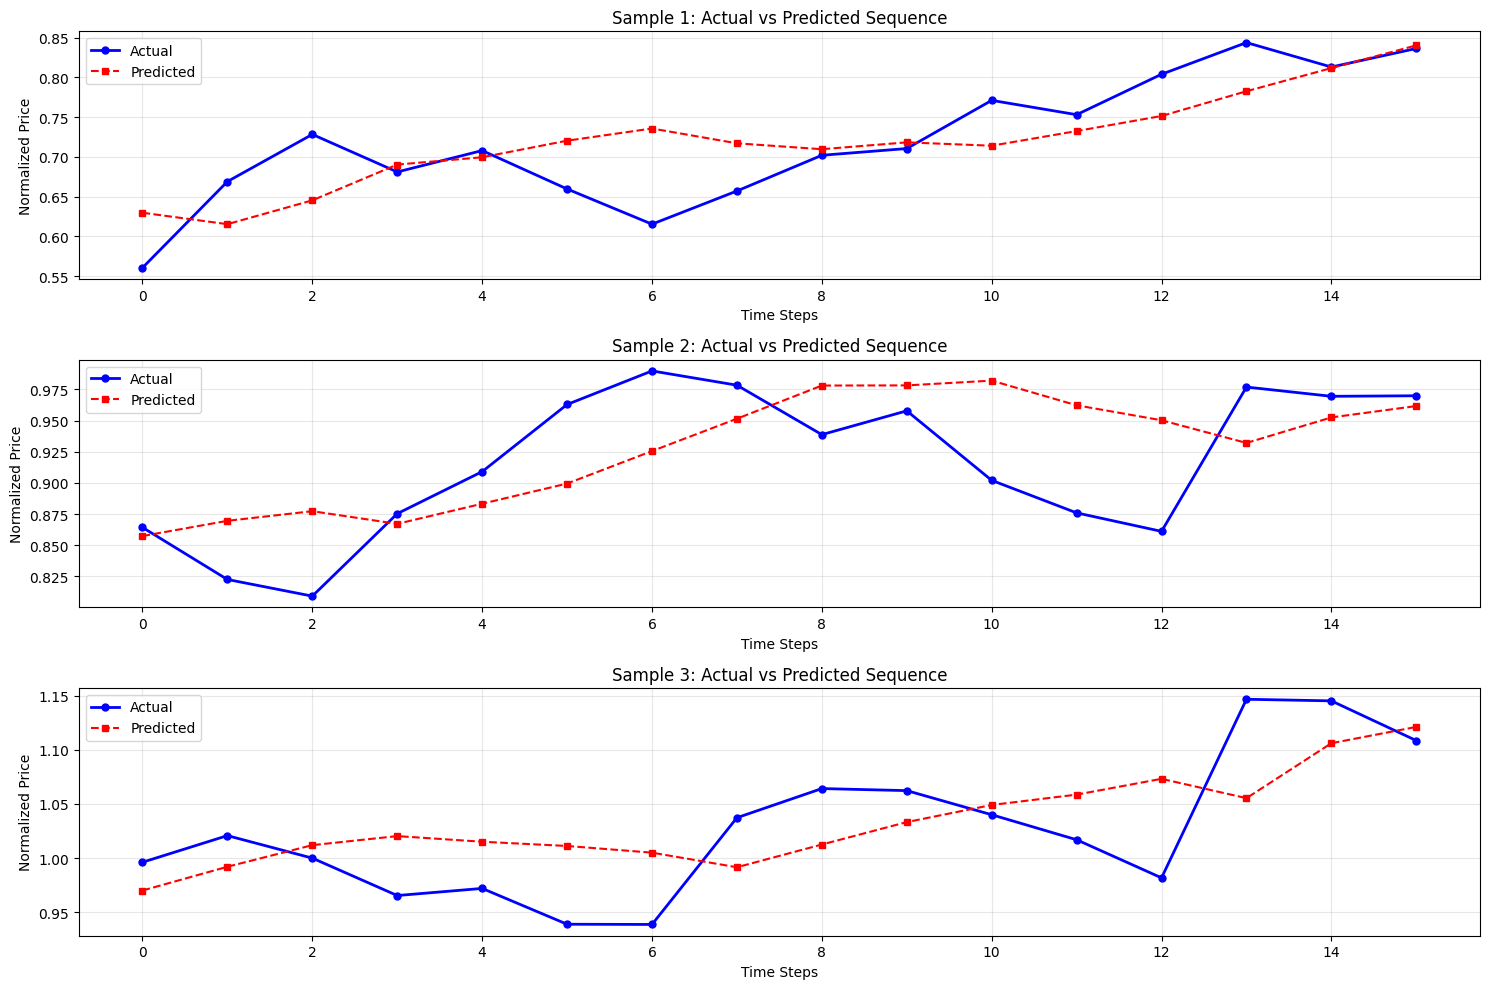

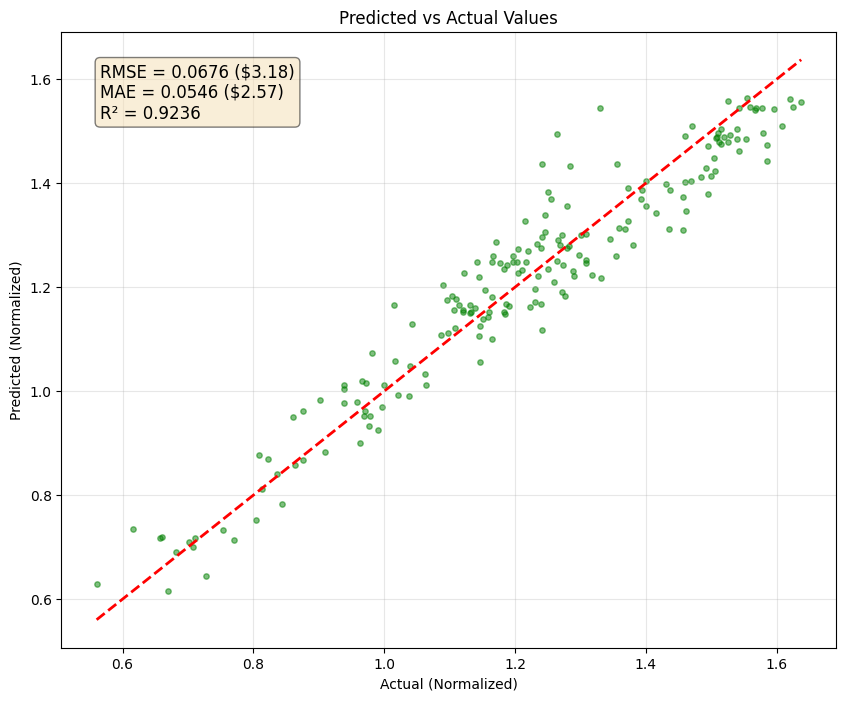

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


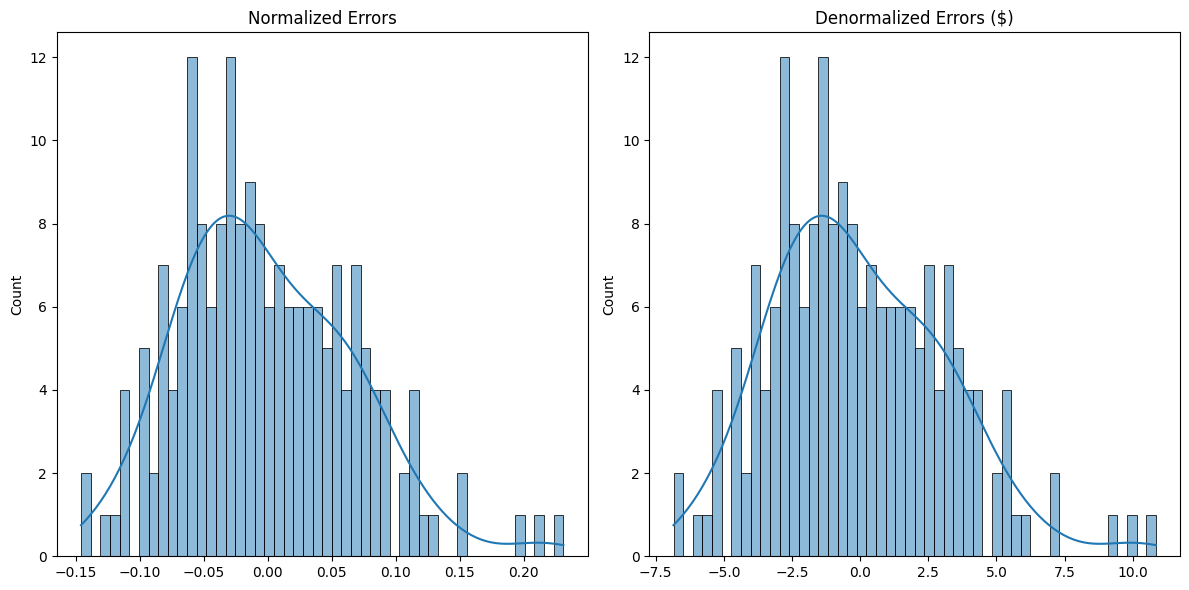

In [44]:
def test_transformer(model, test_loader, target_scaler, original_prices_df):
    """
    Comprehensive testing function with metrics and visualizations
    Args:
        model: Trained transformer model
        test_loader: Test data loader
        target_scaler: Fitted target scaler
        original_prices_df: DataFrame with original prices for reference
    """
    model.eval()
    all_predictions = []
    all_ground_truth = []
    
    # Store for sequence plotting
    sequence_preds = []
    sequence_actuals = []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            outputs = model(X_test)
            all_predictions.extend(outputs.cpu().numpy())
            all_ground_truth.extend(y_test.squeeze().cpu().numpy())
            
            # Store last 3 sequences for plotting
            if len(sequence_preds) < 3:
                sequence_preds.append(outputs.cpu().numpy())
                sequence_actuals.append(y_test.squeeze().cpu().numpy())
    
    # Convert to numpy arrays
    y_pred = np.array(all_predictions)
    y_true = np.array(all_ground_truth)
    
    # Inverse transform if scaler provided
    y_pred_denorm = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true_denorm = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    original_mean = original_prices_df['Close'].mean()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    
    # Calculate MAPE only for prices > $5 to avoid division by small numbers
    valid_prices_mask = y_true_denorm > 5
    mape_denorm = np.mean(np.abs((y_true_denorm[valid_prices_mask] - y_pred_denorm[valid_prices_mask]) / 
                         y_true_denorm[valid_prices_mask])) * 100

    # 1. Time-series comparison plot with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAPL Stock Prediction\nTrue Range: ${original_prices_df['Close'].min():.2f}-${original_prices_df['Close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print metrics
    print(f"\nNormalized Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f} ({(rmse_denorm/original_mean)*100:.1f}% of mean price)")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE (>$5 prices): {mape_denorm:.2f}%")

    # 2. Sample sequence plots
    plt.figure(figsize=(15, 10))
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(sequence_actuals[i], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(sequence_preds[i], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {i+1}: Actual vs Predicted Sequence")
        plt.xlabel("Time Steps")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Scatter plot with metrics
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual (Normalized)")
    plt.ylabel("Predicted (Normalized)")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    plt.show()

    # 4. Error distribution plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    plt.tight_layout()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'rmse_denorm': rmse_denorm,
        'mae_denorm': mae_denorm,
        'mape_denorm': mape_denorm
    }

# Example usage:
test_results = test_transformer(trained_model, test_loader, target_scaler, df)